#DataSet Prep - Dont Change This

In [104]:
# ✅ Mount Google Drive (if in Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# ✅ Base folder and model folders
base_folder = "/content/drive/MyDrive/Legora-Evaluation"
model_folders = ["eval_Gemini", "eval_Google_Flan", "eval_Openai", "eval_ Llama"]

all_records = []

In [106]:
# ✅ Load JSON files from each model's folder
for model in model_folders:
    folder = os.path.join(base_folder, model)
    files = glob.glob(os.path.join(folder, "*.json"))

    for f in files:
        with open(f) as file:
            data = json.load(file)
            data["Model"] = model  # Add model identifier
            all_records.append(data)

In [107]:
# ✅ Create combined DataFrame
combined_df = pd.DataFrame(all_records)


In [108]:
combined_df = combined_df[[
    "Model", "Contract ID", "Precision", "Recall", "F1 Score",
    "Avg Cosine Similarity", "Extracted Clauses"
]]


In [109]:
# ✅ Save as Excel
combined_df.to_excel(os.path.join(base_folder, "final_llm_comparison.xlsx"), index=False)

print("✅ final_llm_comparison.xlsx created with all models including LLaMA.")

✅ final_llm_comparison.xlsx created with all models including LLaMA.


In [110]:
print("Models in combined_df:", combined_df["Model"].unique())


Models in combined_df: ['eval_Gemini' 'eval_Google_Flan' 'eval_Openai' 'eval_ Llama']


#Evaluate

In [1]:
!pip install pandas openpyxl sentence-transformers seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [120]:
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

In [133]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# Step 2: Load LLM and benchmark data
llm_df = pd.read_excel(f"{base_folder}/final_llm_comparison.xlsx")
benchmark_df = pd.read_excel(f"{base_folder}/Benchmark_Datset.xlsx")

llm_df["Extracted Clauses"] = llm_df["Extracted Clauses"].fillna("").astype(str)
benchmark_df["Clause Text"] = benchmark_df["Clause Text"].fillna("").astype(str)
merged_df = pd.merge(llm_df, benchmark_df, on="Contract ID", how="inner")


In [135]:
# Step 3: Semantic Similarity using LegalBERT
model = SentenceTransformer("nlpaueb/legal-bert-base-uncased")
llm_embeddings = model.encode(merged_df["Extracted Clauses"].tolist(), convert_to_tensor=True)
human_embeddings = model.encode(merged_df["Clause Text"].tolist(), convert_to_tensor=True)
semantic_scores = util.cos_sim(llm_embeddings, human_embeddings).diagonal().cpu().numpy()
merged_df["LegalBERT Semantic Similarity"] = semantic_scores

In [136]:
# Step 4: Summary Table (semantic similarity)
avg_similarity = merged_df.groupby("Model")["LegalBERT Semantic Similarity"].mean().reset_index()


<ipython-input-137-ea6e48292ba4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_similarity, x="Model", y="LegalBERT Semantic Similarity", palette='crest')


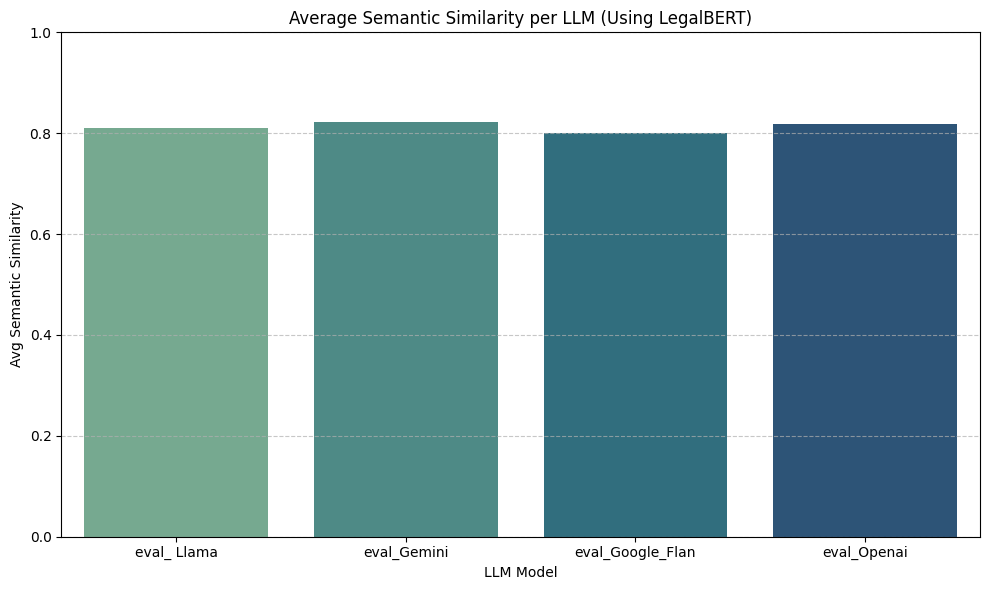

In [137]:
# 1. Average LegalBERT Similarity per Model
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_similarity, x="Model", y="LegalBERT Semantic Similarity", palette='crest')
plt.title("Average Semantic Similarity per LLM (Using LegalBERT)")
plt.xlabel("LLM Model")
plt.ylabel("Avg Semantic Similarity")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [138]:
# Step 5: Average similarity per model
avg_similarity = merged_df.groupby("Model")["LegalBERT Semantic Similarity"].mean().reset_index()


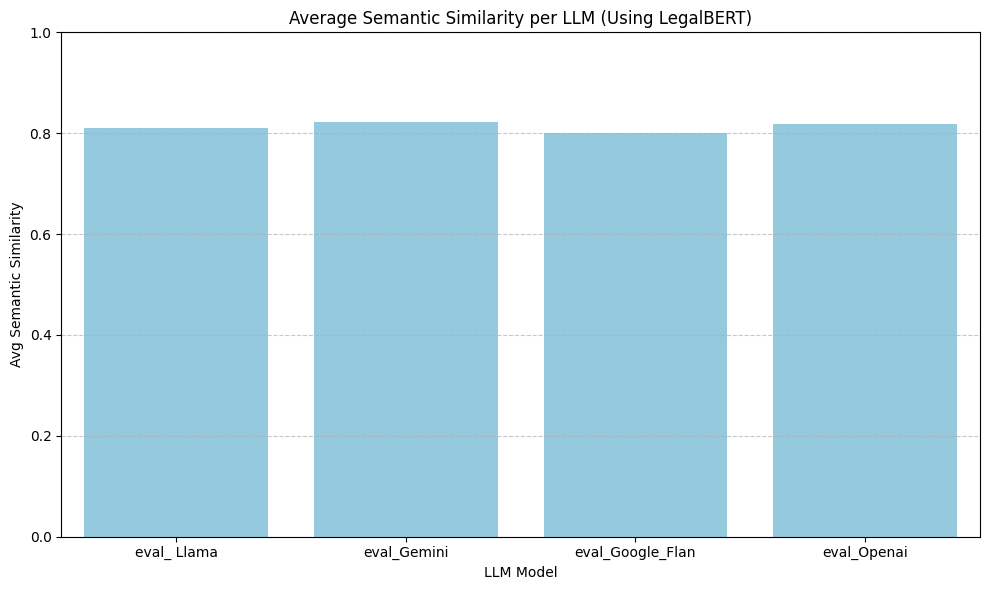

In [139]:
# Avg LegalBERT similarity
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_similarity, x="Model", y="LegalBERT Semantic Similarity", color='skyblue')
plt.title("Average Semantic Similarity per LLM (Using LegalBERT)")
plt.xlabel("LLM Model")
plt.ylabel("Avg Semantic Similarity")
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

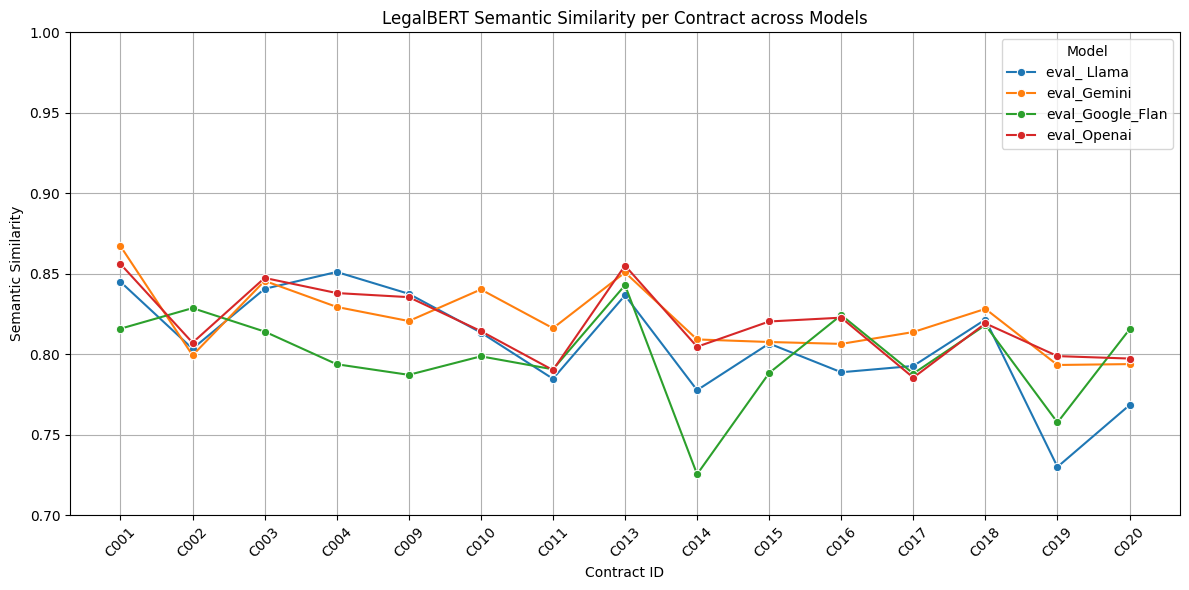

In [140]:
# Lineplot: per contract
contract_similarity_df = merged_df.groupby(["Contract ID", "Model"])["LegalBERT Semantic Similarity"].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=contract_similarity_df, x="Contract ID", y="LegalBERT Semantic Similarity", hue="Model", marker="o")
plt.title("LegalBERT Semantic Similarity per Contract across Models")
plt.xlabel("Contract ID")
plt.ylabel("Semantic Similarity")
plt.xticks(rotation=45)
plt.ylim(0.7, 1)
plt.tight_layout()
plt.grid(True)
plt.show()

<ipython-input-141-32f25532257d>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=llm_df, x="Model", y="Avg Cosine Similarity", estimator="mean", ci="sd")


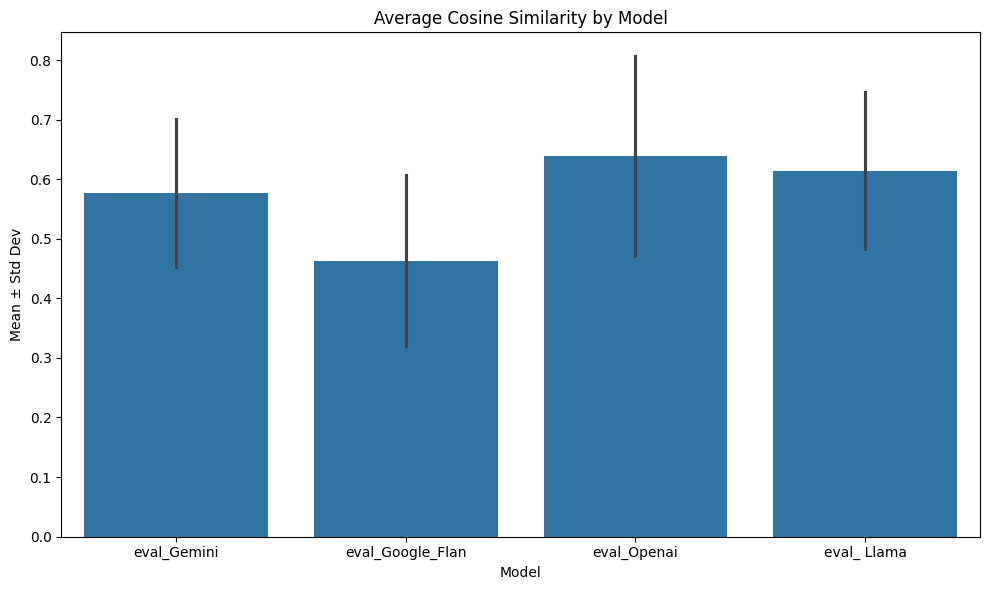

In [141]:
# Avg Cosine Similarity per model
plt.figure(figsize=(10, 6))
sns.barplot(data=llm_df, x="Model", y="Avg Cosine Similarity", estimator="mean", ci="sd")
plt.title("Average Cosine Similarity by Model")
plt.ylabel("Mean ± Std Dev")
plt.tight_layout()
plt.show()

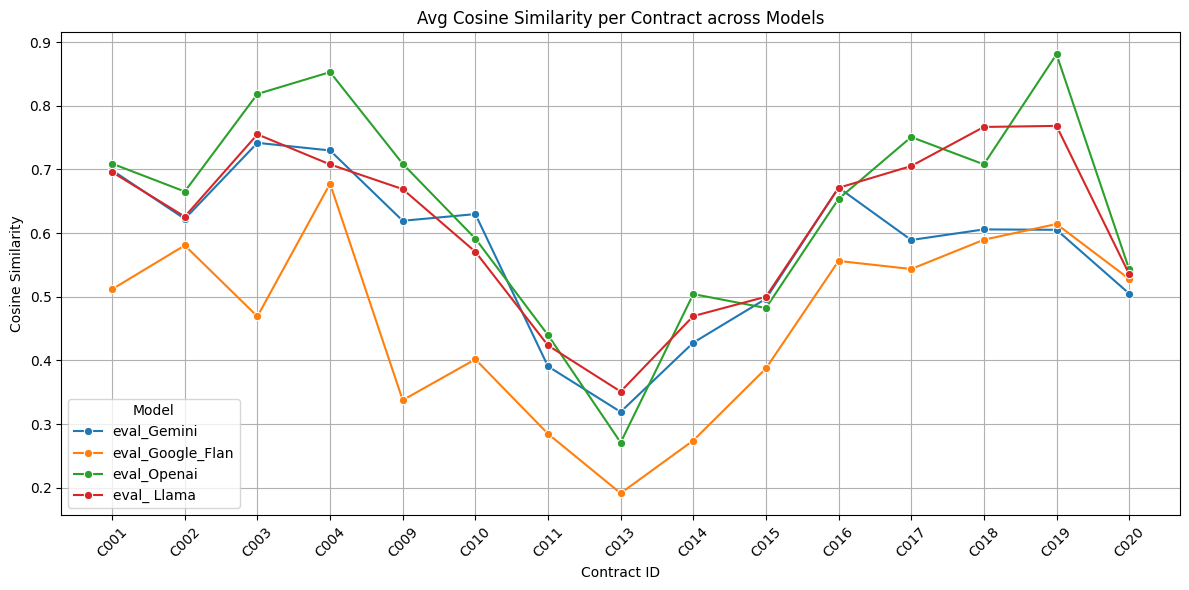

In [142]:
# Cosine Similarity per contract
plt.figure(figsize=(12, 6))
sns.lineplot(data=llm_df, x="Contract ID", y="Avg Cosine Similarity", hue="Model", marker="o")
plt.title("Avg Cosine Similarity per Contract across Models")
plt.xticks(rotation=45)
plt.ylabel("Cosine Similarity")
plt.tight_layout()
plt.grid(True)
plt.show()

In [143]:
# ✅ Generate Summarized Evaluation Table per Model
summary_table = llm_df.groupby("Model")[["Precision", "Recall", "F1 Score", "Avg Cosine Similarity"]].mean()
summary_table["LegalBERT Semantic Similarity"] = avg_similarity.set_index("Model")["LegalBERT Semantic Similarity"]

# Optional: Round for display
summary_table = summary_table.round(3)

# ✅ Print Summary Table
print("🔍 Summarized Evaluation Metrics per Model:\n")
print(summary_table)

# ✅ Save to Excel (with all metrics)
summary_table.to_excel(f"{base_folder}/evaluation_summary_table.xlsx")

🔍 Summarized Evaluation Metrics per Model:

                  Precision  Recall  F1 Score  Avg Cosine Similarity  \
Model                                                                  
eval_ Llama           0.002   0.233     0.004                  0.614   
eval_Gemini           0.001   0.117     0.003                  0.577   
eval_Google_Flan      0.002   0.022     0.004                  0.463   
eval_Openai           0.003   0.261     0.006                  0.639   

                  LegalBERT Semantic Similarity  
Model                                            
eval_ Llama                               0.810  
eval_Gemini                               0.821  
eval_Google_Flan                          0.801  
eval_Openai                               0.819  


In [145]:
# Step 7: Save results to Excel
with pd.ExcelWriter(f"{base_folder}/legalbert_similarity_evaluation.xlsx") as writer:
    merged_df.to_excel(writer, sheet_name="Clause-Level Similarity", index=False)
    avg_similarity.to_excel(writer, sheet_name="Model-Level Summary", index=False)